In [1]:
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/tracking/')
sys.path.insert(1, '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/utils/')
from data_loading import *
from hit import Hit
from track3D import Track3D
from track import Track
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import sys
from tqdm import tqdm
import scienceplots
plt.style.use(['science', 'grid', 'ieee'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern Roman",
    'text.latex.preamble': [r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{siunitx}'],
    'figure.dpi': 140,
    'font.size': 14,
    'axes.grid': True
})


In [2]:
# later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing
file_path = '/Users/lucahartman/Documents/EPFL/MA1/project/ecal_reco/geant4/data_MIP4.root'

# branch_list = ['E', 'Edep', 'pdg', 'EcalEdep',
#                'layerID', 'barID', 'Nhits', 'tx', 'ty', 'x0', 'y0', 'n_sec',
#                'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
# with uproot.open(file_path) as tree:
#         hits_dict = tree['events'].arrays(branch_list, library="np")
# df_hits = pd.DataFrame.from_dict(hits_dict)

branch_list_detector = ['E', 'pdg', 'EcalEdep', 'layerID', 'barID', 'Nhits', 'Edep_e', 'Edep_mu']
branch_list_run = ['E', 'Edep', 'tx', 'ty', 'x0', 'y0', 'n_sec', 'ProcessID', 'x_decay', 'y_decay', 'z_decay', 'size_XY', 'size_Z']
branch_list_electrons = ['E', 'Vertex_E', 'muID']
with uproot.open(file_path) as tree:
        detector_dict = tree['detector'].arrays(branch_list_detector, library="np")
        run_dict = tree['run'].arrays(branch_list_run, library="np")
        electrons_dict = tree['electrons'].arrays(branch_list_electrons, library="np")

df_detector = pd.DataFrame.from_dict(detector_dict)
df_run = pd.DataFrame.from_dict(run_dict)
df_electrons = pd.DataFrame.from_dict(electrons_dict)
df = pd.concat([df_run, df_detector, df_electrons], axis=1)

In [8]:
edeps = []
for index, row in tqdm(df.iterrows(), total = df.shape[0]):
    row_edeps = row['EcalEdep']
    edeps.extend([re for re in row_edeps if re > 0])

100%|██████████| 100000/100000 [00:05<00:00, 18267.93it/s]


MAX: E=0.63500
MEAN: E=0.91394


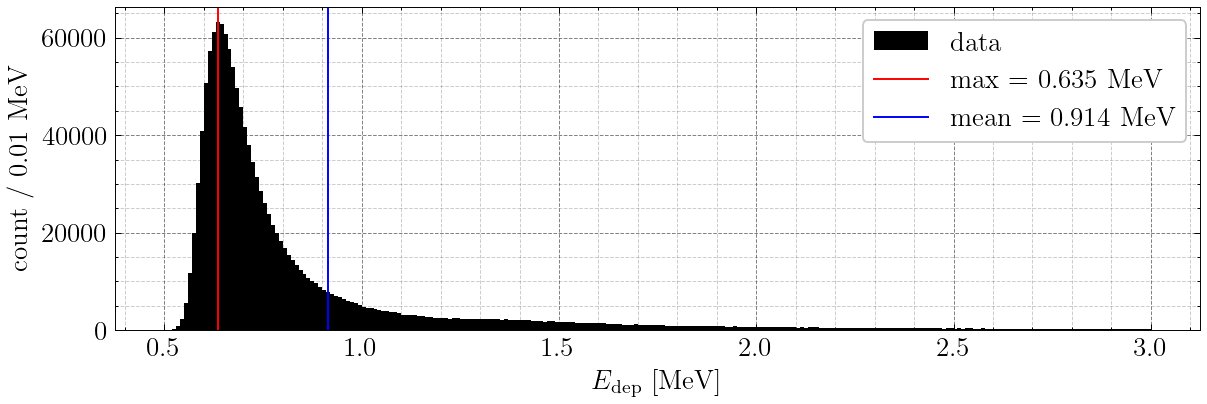

In [15]:
edeps_MeV = np.array(edeps)
plt.figure(figsize=(10,3))
h, xs, _ = plt.hist(edeps_MeV, bins=250, range=[0.5, 3], label='data')
max_arg = np.argmax(h)
xs = np.array(xs) + (xs[1] - xs[0])/2
print('MAX: E={:.5f}'.format(xs[max_arg]))
m = np.mean(edeps_MeV)
print('MEAN: E={:.5f}'.format(m))
plt.axvline(xs[max_arg], 0, 1, c='r',
            label='max = {:.3f} MeV'.format(xs[max_arg]))
plt.axvline(m, 0, 1, c='b', label='mean = {:.3f} MeV'.format(m))
plt.legend()
plt.xlabel(r'$E_\mathrm{dep}$ [MeV]')
plt.ylabel(r'count / $0.01$ MeV')
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)

In [3]:
from parameters import *

def get_hits(row):
    return [[row['barID'][i], row['layerID'][i], row['EcalEdep'][i]] for i in range(len(row['barID']))
            if row['EcalEdep'][i] > 0]

def create_tracks(df, plot=False):
    tracks = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        hits = get_hits(row)
        if len(hits) > 0:
            hitsX = [Hit([bar, (layer-1)/2 + 1], True, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 1]
            hitsY = [Hit([bar, layer/2 + 1], False, 0, 0, e) for (bar, layer, e) in hits if layer % 2 == 0]
            
            # get track parameters
            if len(hitsX) > 1 and len(hitsY) > 1:
                track = Track3D()
                track.x = Track(hitsX)
                track.y = Track(hitsY)
                tracks.append(track)

    return tracks


In [4]:
tracks = create_tracks(df)
# import line_profiler
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(100))


100%|██████████| 100000/100000 [26:03<00:00, 63.97it/s]


####### Track # 7600


Text(0.5, 0, '$Edep$ [GeV]')

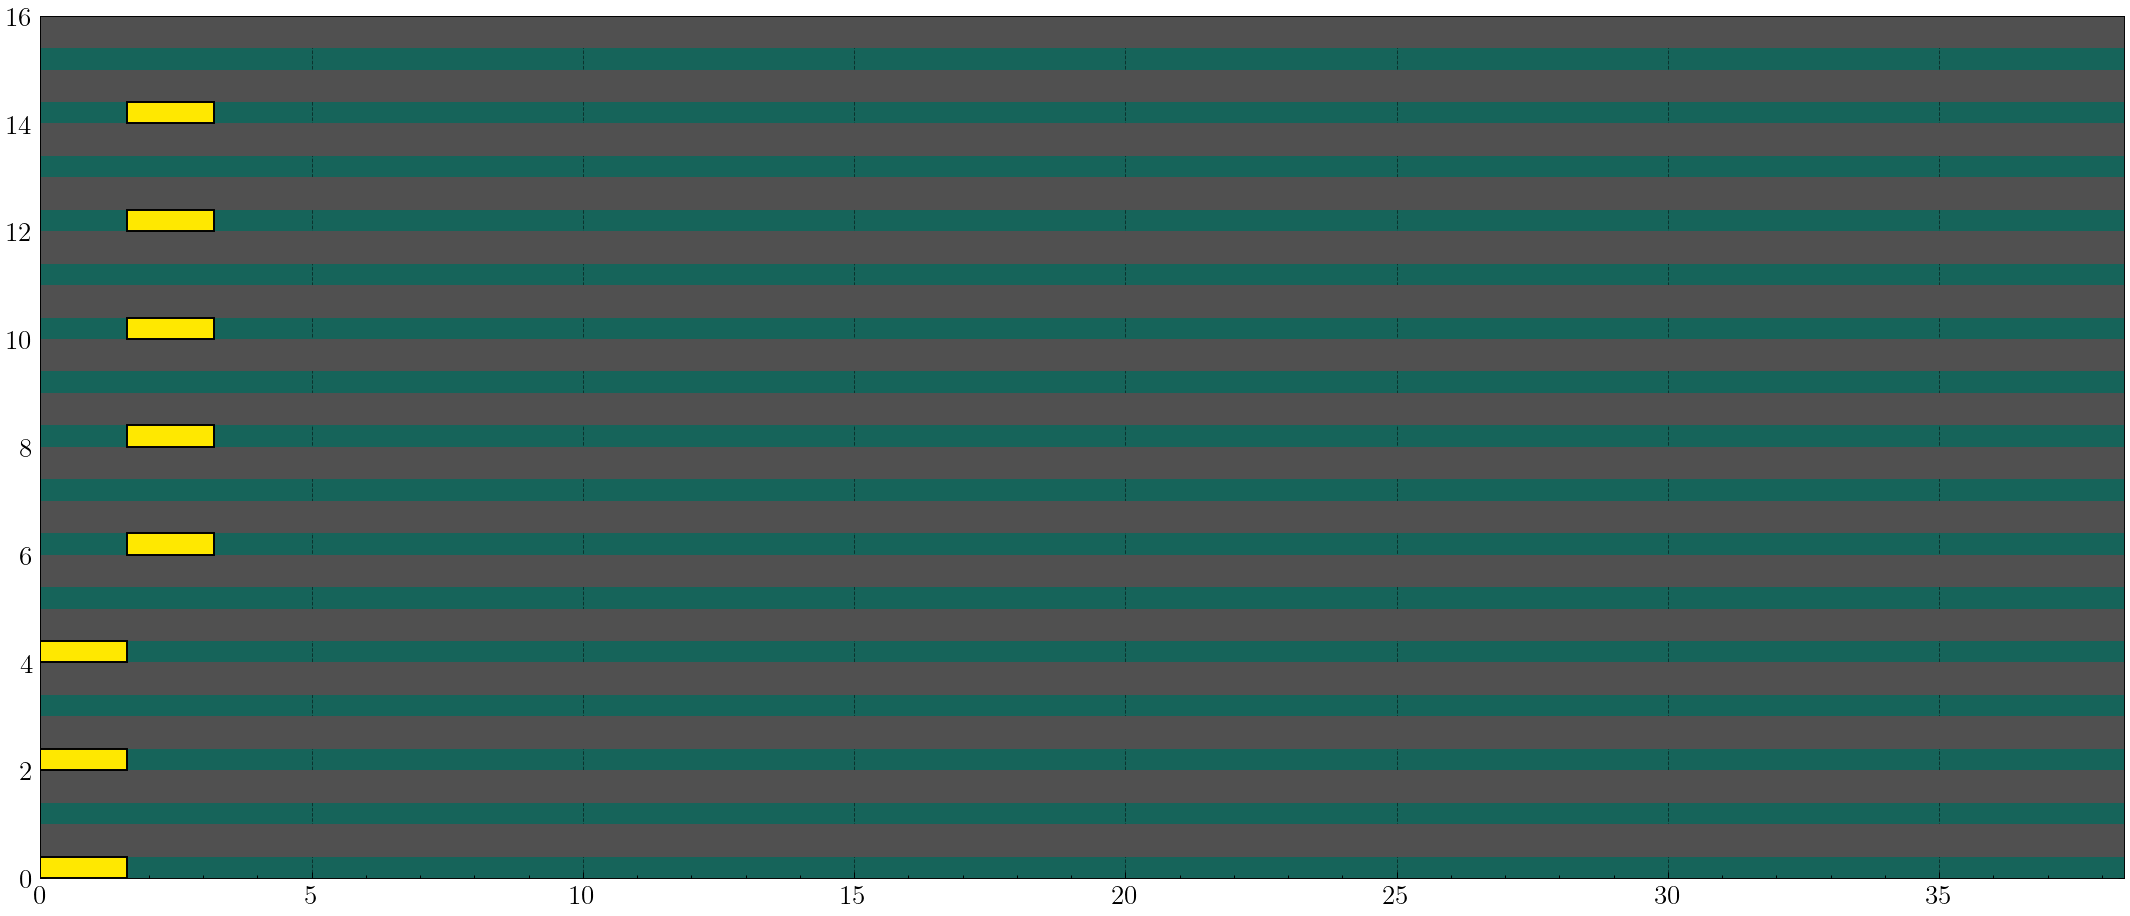

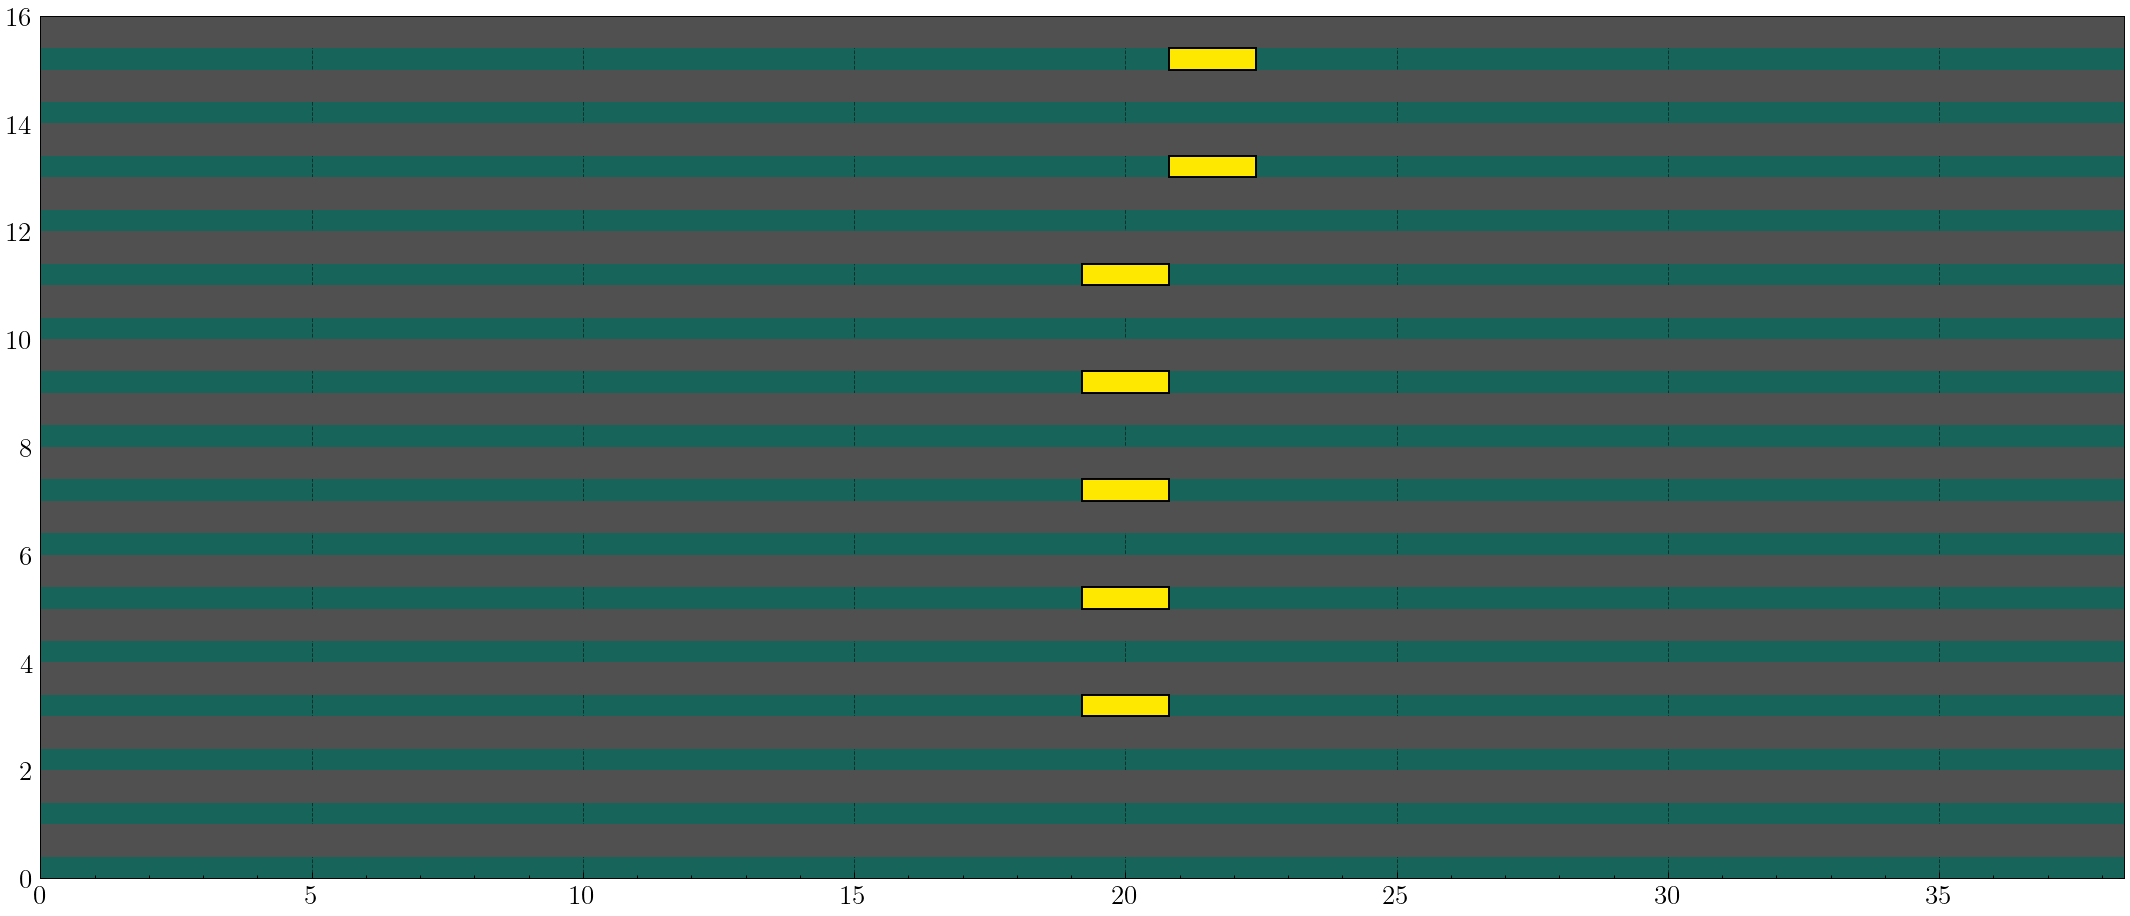

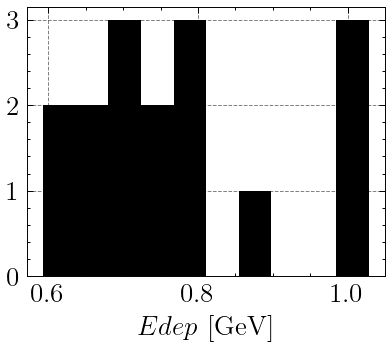

In [5]:
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)

edeps = [h.value for h in t.x.hits]
edeps.extend([h.value for h in t.y.hits])
plt.figure()
plt.hist(edeps, bins = 10)
plt.xlabel('$Edep$ [GeV]')


13
MAX: E=0.63500
MEAN: E=0.91421


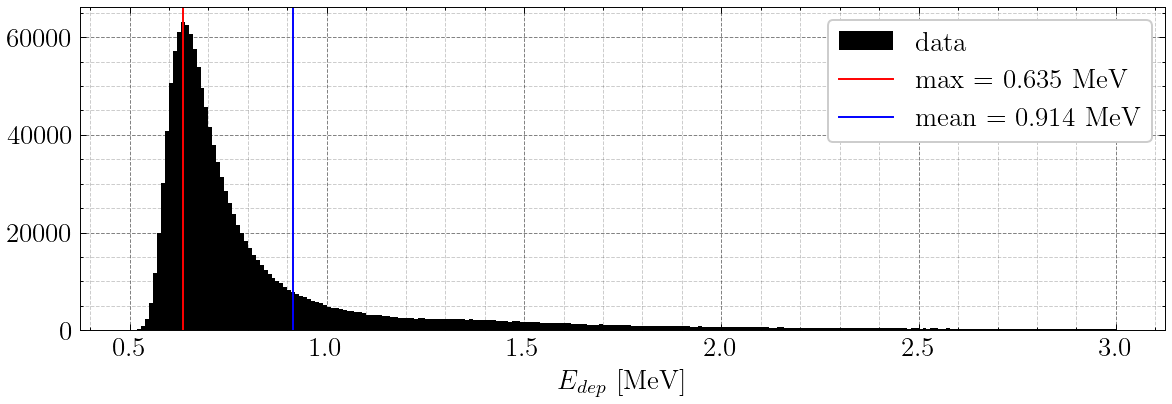

In [6]:
edeps = []
for t in tracks:
    edeps.extend([h.value for h in t.x.hits])
    edeps.extend([h.value for h in t.y.hits])

edeps_MeV = np.array(edeps)
plt.figure(figsize=(10, 3))
h, xs, _ = plt.hist(edeps_MeV, bins=250, range=[0.5, 3], label='data')
plt.xlabel('$E_{dep}$ [MeV]')
max_arg = np.argmax(h)
print(max_arg)
xs = np.array(xs) + (xs[1] - xs[0])/2
print('MAX: E={:.5f}'.format(xs[max_arg]))
m = np.mean(edeps_MeV)
print('MEAN: E={:.5f}'.format(m))
plt.axvline(xs[max_arg], 0, 1, c='r', label='max = {:.3f} MeV'.format(xs[max_arg]))
plt.axvline(m, 0, 1, c='b', label='mean = {:.3f} MeV'.format(m))
plt.legend()
plt.grid(which = 'major', alpha = 0.5)
plt.grid(which = 'minor', alpha = 0.2)
plt.savefig('../../../figs/MIP.pdf')

In [7]:
with open('MIP_data.npy', 'wb') as f:
    np.save(f, np.array(tracks))